Pretty much copied verbatim from https://musicinformationretrieval.com/ipython_audio.html

In [1]:
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

https://musicinformationretrieval.com/stft.html

In [2]:
audio, sampling_rate = librosa.load('Scale.m4a') # sample.mp3 / Scale.m4a
ipd.Audio(audio, rate=sampling_rate)

/home/yasu/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [3]:
print(f"audio.shape\t{audio.shape}")
print(f"sampling rate\t{sampling_rate}")
print(f"duration\t{audio.shape[0]/sampling_rate} seconds")

audio.shape	(457300,)
sampling rate	22050
duration	20.73922902494331 seconds


## [librosa.stft](https://librosa.org/doc/latest/generated/librosa.stft.html?highlight=stft#librosa.stft)
* n_fft: length of windowed signal, defaults to 2048 (power of 2 recommended)
* hop_length: audio samples bet. adjacent STFT columns. (probably means there's some overlap between each column)

In [4]:
hop_length = 512
n_fft = 2048
stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
stft_result.shape

(1025, 894)

In [5]:
stft_magnitude = abs(stft_result)
stft_decibel = librosa.amplitude_to_db(stft_magnitude)
stft_phase = numpy.angle(stft_result)

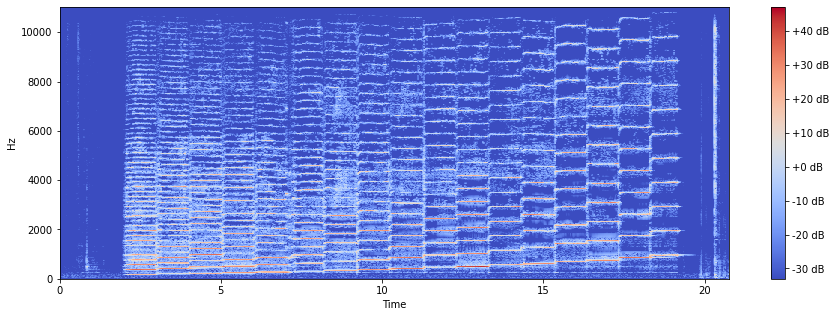

In [6]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(stft_decibel, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

In [7]:
stft_phase[:10]

array([[ 0.0000000e+00,  0.0000000e+00,  3.1415927e+00, ...,
         0.0000000e+00,  3.1415927e+00,  3.1415927e+00],
       [-3.1415927e+00,  1.0960130e-01, -9.5494872e-01, ...,
        -1.2518576e-01, -2.1585920e+00, -2.7077228e-01],
       [-3.1415927e+00,  7.4976540e-01,  4.6312317e-01, ...,
        -2.4818902e+00, -7.4510670e-01,  2.5923195e+00],
       ...,
       [ 2.1037654e-16, -2.0556030e+00,  2.8827953e+00, ...,
        -2.7412485e-02, -1.5446948e+00, -2.2375717e+00],
       [-3.1415927e+00, -1.6459856e+00, -1.5000838e+00, ...,
        -2.8637958e+00,  2.2827394e+00,  1.1232625e+00],
       [-7.0228693e-17, -6.0670400e-01,  1.9781630e-01, ...,
         9.9728525e-01,  2.3722992e+00, -2.1424417e+00]], dtype=float32)

## constant-Q transform
uses logarithmically-spaced frequency axis...

In [8]:
fmin = librosa.midi_to_hz(36)
C = librosa.cqt(audio, sr=sampling_rate)
logC = librosa.amplitude_to_db(abs(C))

/home/yasu/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


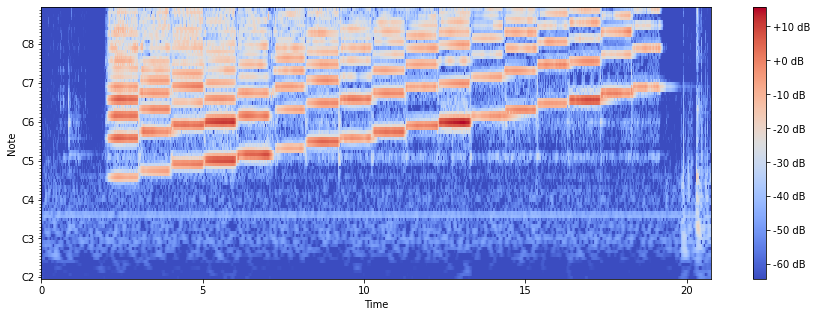

In [9]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sampling_rate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')

# reconstruct audio from FFT

The original piece is reconstructed pretty well:

In [10]:
reconstructed_audio = librosa.istft(stft_result)
print(reconstructed_audio.shape)
ipd.Audio(reconstructed_audio, rate=sampling_rate)

(457216,)


It sounds a bit worse when reconstructed without phase data, but I think it's good enough for experimentation.

In [11]:
reconstructed_audio = librosa.istft(stft_magnitude)
print(reconstructed_audio.shape)
ipd.Audio(reconstructed_audio, rate=sampling_rate)

(457216,)


# Reconstruction from a single slice of FFT
if this manages to somewhat recreate the original tone, then there's hope that a naive implementation of the autoencoder will let me control the sound by manipulating the latent space and turning the output into sound.

In [12]:
sample_slice = numpy.expand_dims(stft_result[:,100], 0).transpose()
print(sample_slice.shape)
stft_constant = numpy.repeat(sample_slice, 100, axis=1)
print(stft_constant.shape)

reconstructed_audio = librosa.istft(stft_constant)
print(reconstructed_audio.shape)
ipd.Audio(reconstructed_audio, rate=sampling_rate)

(1025, 1)
(1025, 100)
(50688,)


with phase data removed, it actually sounds about the same (as it should be? since it probably shouldn't matter what phase each frequency is, when the magnitude doesn't change)

In [13]:
reconstructed_audio = librosa.istft(abs(stft_constant))
ipd.Audio(reconstructed_audio, rate=sampling_rate)